# IMDB 영화 리뷰 감성 분류
- Test data 25,000건중 10,000건은 Validation data로 활용

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [4]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=None)

17465344/17464789 [==============================] - 0s 0us/step


In [5]:
index_dict = {}
for key, value in imdb.get_word_index().items():
    index_dict[value] = key
len(index_dict)

1646592/1641221 [==============================] - 0s 0us/step


88584

In [6]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [7]:
# 리뷰의 길이
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train)) 

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


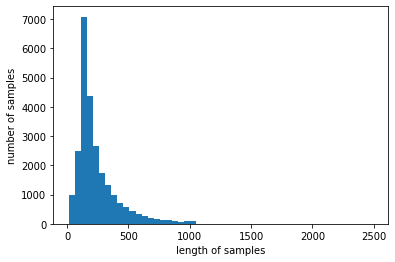

In [8]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
# 레이블의 분포
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


## LSTM으로 IMDB 리뷰 감성 분류
- 모든 단어가 아닌 빈도수 5000 까지 (총 단어수: 88,584)
- 모든 문장이 아니라 500 단어까지 (최대 2,494 단어)
- Test data 25,000건중 10,000건은 Validation data로 활용

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

In [12]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 500으로 맞춤
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- Test data set을 검증 셋과 테스트 셋으로 분리

In [13]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=.6, random_state=seed
)

### 모델 정의/설정/학습/평가

In [14]:
# LSTM 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 715,801
Trainable params: 715,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_lstm_best_model.h5', monitor='val_loss', 
                     verbose=1, save_best_only=True)

In [18]:
# 모델의 실행
history = model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es]) 

Epoch 1/50
250/250 - 22s - loss: 0.4557 - accuracy: 0.7804 - val_loss: 0.4012 - val_accuracy: 0.8237

Epoch 00001: val_loss improved from inf to 0.40116, saving model to model/imdb_lstm_best_model.h5
Epoch 2/50
250/250 - 14s - loss: 0.2810 - accuracy: 0.8877 - val_loss: 0.2974 - val_accuracy: 0.8764

Epoch 00002: val_loss improved from 0.40116 to 0.29742, saving model to model/imdb_lstm_best_model.h5
Epoch 3/50
250/250 - 14s - loss: 0.2269 - accuracy: 0.9111 - val_loss: 0.3042 - val_accuracy: 0.8797

Epoch 00003: val_loss did not improve from 0.29742
Epoch 4/50
250/250 - 14s - loss: 0.2152 - accuracy: 0.9155 - val_loss: 0.3470 - val_accuracy: 0.8732

Epoch 00004: val_loss did not improve from 0.29742
Epoch 5/50
250/250 - 14s - loss: 0.1617 - accuracy: 0.9395 - val_loss: 0.3414 - val_accuracy: 0.8711

Epoch 00005: val_loss did not improve from 0.29742
Epoch 6/50
250/250 - 14s - loss: 0.1313 - accuracy: 0.9518 - val_loss: 0.3732 - val_accuracy: 0.8675

Epoch 00006: val_loss did not impro

In [19]:
# Best Model 선택
best_model = load_model('model/imdb_lstm_best_model.h5')

In [21]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print(f"\n 테스트 정확도: {acc:.4f}")

469/469 - 5s - loss: 0.5922 - accuracy: 0.8580

 테스트 정확도: 0.8580


In [22]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

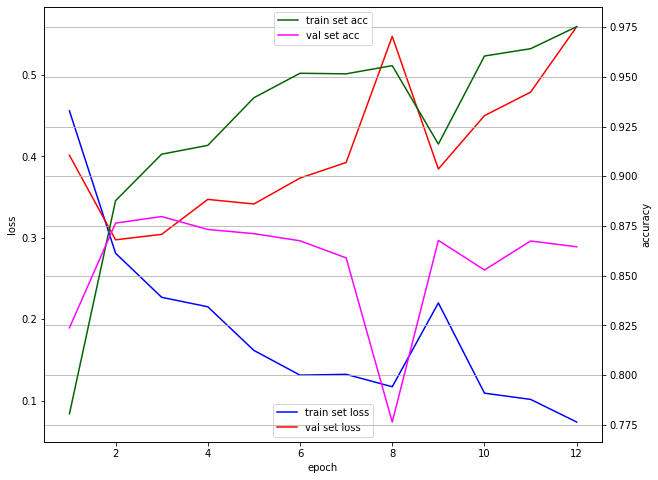

In [23]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='val set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='val set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()